In [ ]:
#Paul's original code:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as pr_auc

# Load the dataset
url = 'https://raw.githubusercontent.com/Mun-Min/Credit_Risk_Classification/main/Resources/lending_data.csv?raw=true'
data = pd.read_csv(url)

# Print the top and bottom 5 rows
print(data.head(5))
print(data.tail(5))
print("")

# Split the data into features (independent variables) and the target variable (default or not)
X = data.drop('loan_status', axis=1)
y = data['loan_status']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict probabilities for the test data
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc_score = pr_auc(recall, precision)

# Calculate Gini coefficient
gini = 2 * roc_auc - 1

# Calculate KS statistic
ks = max(tpr - fpr)

# Print the results
print(f"ROC AUC: {roc_auc:.2f}")
print(f"PR AUC: {pr_auc_score:.2f}")
print(f"Gini: {gini:.2f}")
print(f"KS: {ks:.2f}")

# Create a lift chart
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 1, len(tpr)), tpr, label='Cumulative Response')
plt.plot(np.linspace(0, 1, len(fpr)), fpr, label='Cumulative Non-Response')
plt.xlabel('Fraction of Sample')
plt.ylabel('Cumulative Percentage')
plt.title('Lift Chart')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
y_pred = (y_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy:.2f}")
print("")
print("Confusion Matrix:")
print(confusion)
print("")
print("Classification Report:")
print(classification_rep)


# **Project Assignment #6: Comparative Analysis of Fraud Detection Models**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

## **Step 0: Upload the Data and Exploratory Data Analysis (EDA)**

Step 0: Data Loading and EDA
Dataset shape: (77536, 8)

First few rows:
   loan_size  interest_rate  borrower_income  debt_to_income  num_of_accounts  \
0    10700.0          7.672            52800        0.431818                5   
1     8400.0          6.692            43600        0.311927                3   
2     9000.0          6.963            46100        0.349241                3   
3    10700.0          7.664            52700        0.430740                5   
4    10800.0          7.698            53000        0.433962                5   

   derogatory_marks  total_debt  loan_status  
0                 1       22800            0  
1                 0       13600            0  
2                 0       16100            0  
3                 1       22700            0  
4                 1       23000            0  

Missing values:
loan_size           0
interest_rate       0
borrower_income     0
debt_to_income      0
num_of_accounts     0
derogatory_marks    0
total_debt

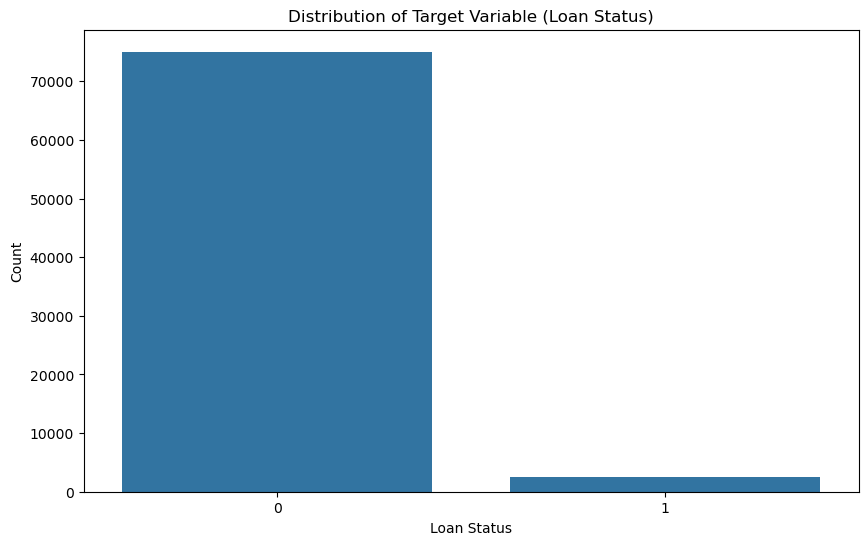

In [3]:
print("Step 0: Data Loading and EDA")

def load_and_explore_data(url):
    """Load data and perform initial exploratory analysis"""
    df = pd.read_csv(url)
    return df

# Load the dataset
url = "https://raw.githubusercontent.com/Mun-Min/Credit_Risk_Classification/main/Resources/lending_data.csv?raw=true"
df = load_and_explore_data(url)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

# Visualize target distribution
plt.figure(figsize=(10, 6))
target_dist = df['loan_status'].value_counts()
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.title('Distribution of Target Variable (Loan Status)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

Extremely imbalanced data

In [4]:
df.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.032243
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.176646
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000


All features are numerical

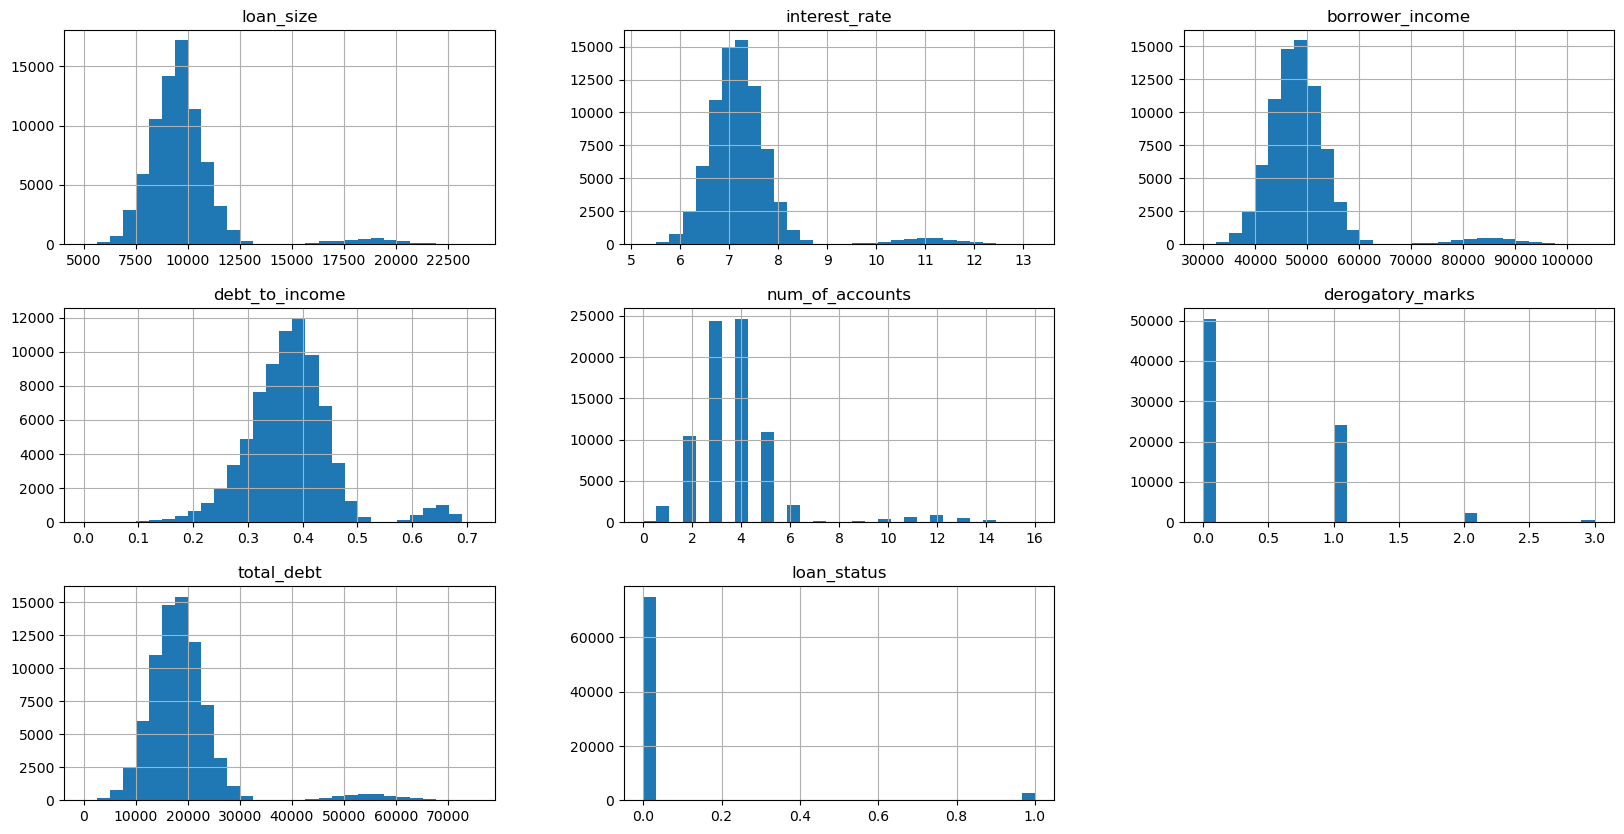

In [6]:
df.hist(bins=30, figsize=(20, 10))
plt.show()

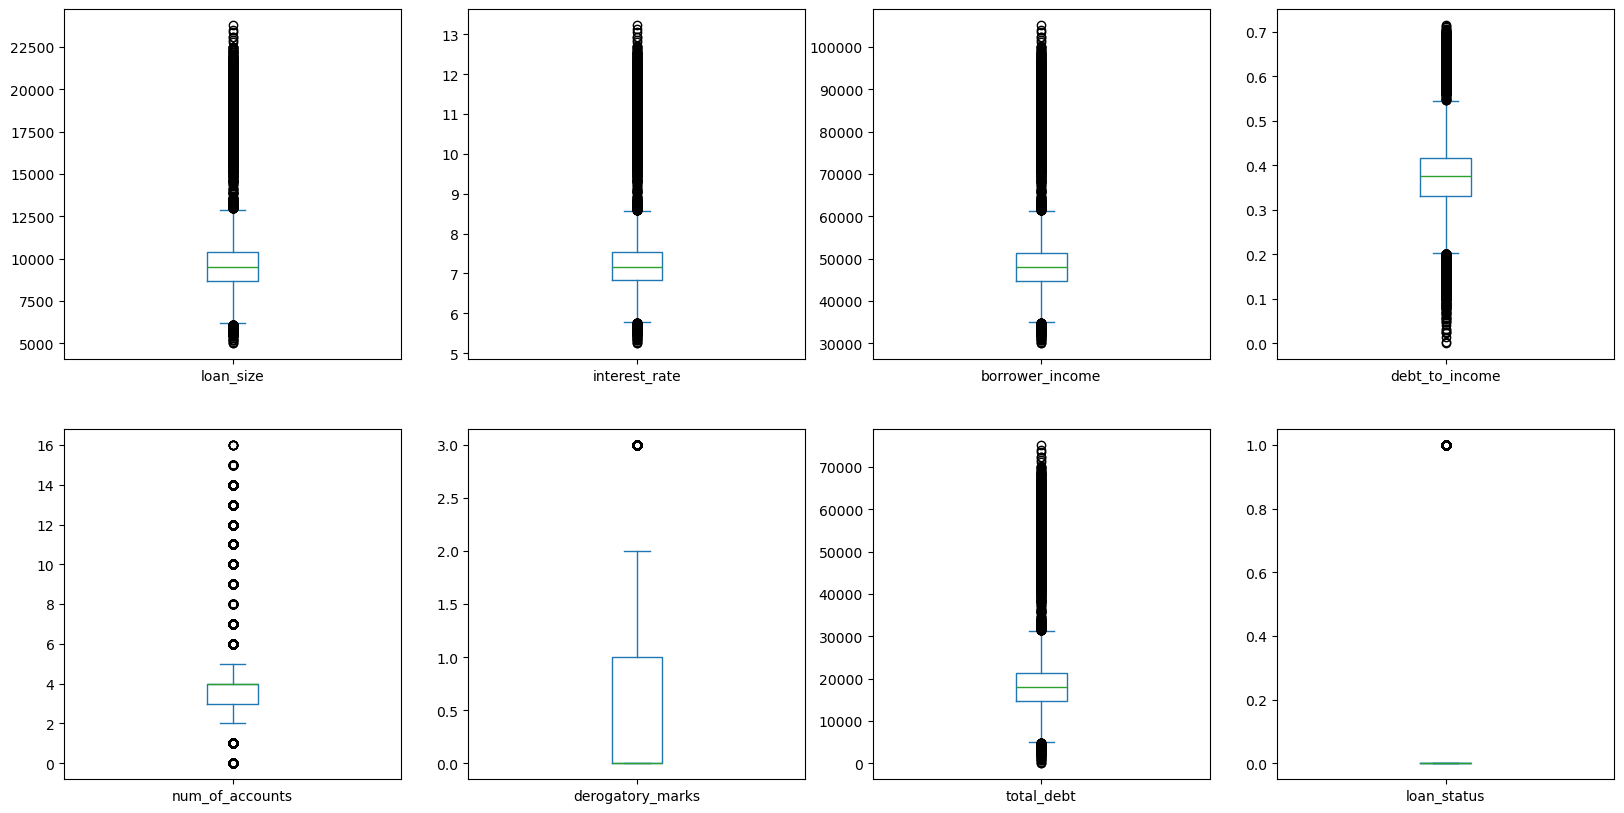

In [7]:
df.plot(kind='box', subplots=True, layout=(2,4), figsize=(20, 10))
plt.show()

There are many outliers

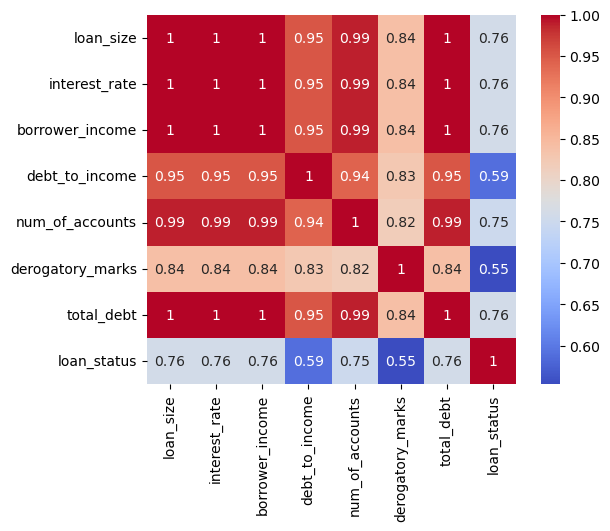

In [9]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.show()

There are some high correlation between features

Analysis of Step 0:
- Dataset contains 77,536 samples and 8 features
- No missing values found
- Target variable shows class imbalance, which we'll address later
- All features are numerical, no categorical encoding needed
- There are plenty outliers
- There are some high correlation between some features

## **Step 1: Model Building**

In [14]:

print("\nStep 1: Model Building")

# Prepare features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_models(X_train, y_train):
    """Build Decision Tree and Random Forest models"""
    # Decision Tree
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    
    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    
    return dt, rf

dt_model, rf_model = build_models(X_train, y_train)



Step 1: Model Building


Analysis of Step 1:
- Successfully built both Decision Tree and Random Forest models
- Used default parameters for initial comparison
- Data split maintains 80-20 ratio for training and testing

## **Step 2: Model Evaluation**


Step 2: Model Evaluation

Decision Tree Performance Metrics:
Precision: 0.8701
Recall: 0.8491

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15011
           1       0.87      0.85      0.86       497

    accuracy                           0.99     15508
   macro avg       0.93      0.92      0.93     15508
weighted avg       0.99      0.99      0.99     15508



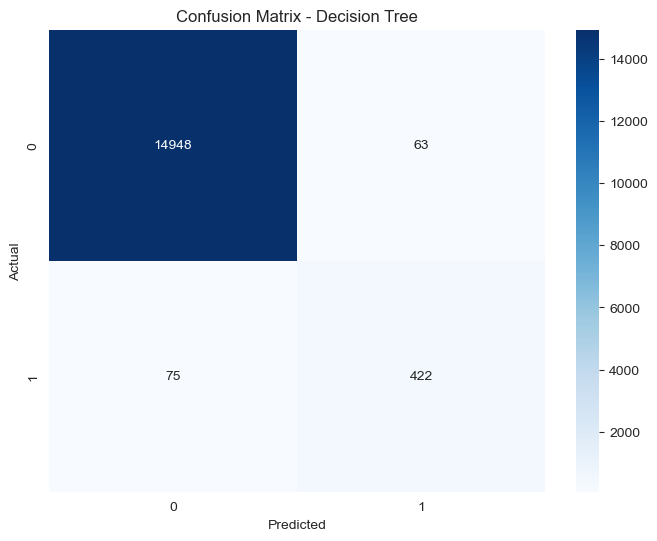


Random Forest Performance Metrics:
Precision: 0.8716
Recall: 0.9014

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15011
           1       0.87      0.90      0.89       497

    accuracy                           0.99     15508
   macro avg       0.93      0.95      0.94     15508
weighted avg       0.99      0.99      0.99     15508



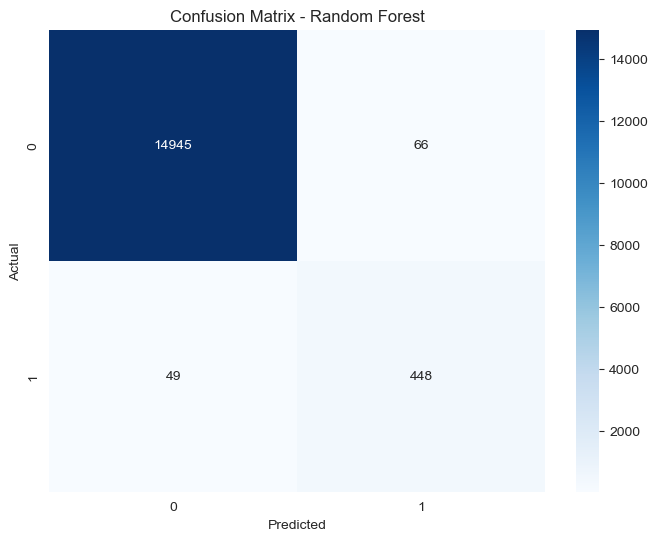

In [15]:
print("\nStep 2: Model Evaluation")

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance with multiple metrics"""
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return precision, recall, cm

dt_precision, dt_recall, dt_cm = evaluate_model(dt_model, X_test, y_test, "Decision Tree")
rf_precision, rf_recall, rf_cm = evaluate_model(rf_model, X_test, y_test, "Random Forest")

Analysis of Step 2:
- Both models show good performance, but Random Forest appears superior (f1=0.89 vs f1=0.86 for the loan_status label "1"/default)
- Random Forest achieves better precision and recall
- Confusion matrices show fewer false positives/negatives for Random Forest

## **Step 3: Comparative Analysis**


Step 3: Comparative Analysis


<Figure size 1000x600 with 0 Axes>

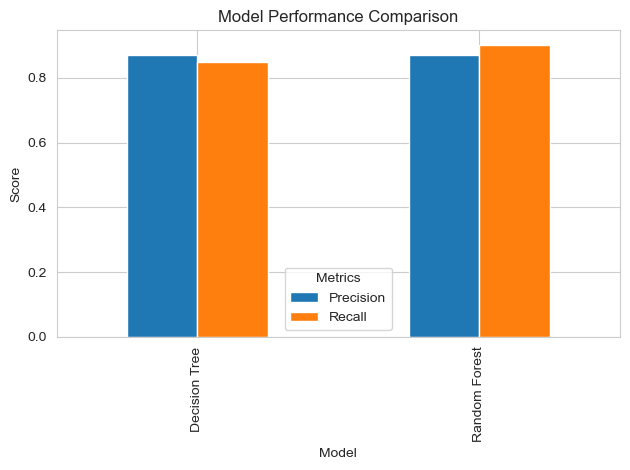

In [16]:
print("\nStep 3: Comparative Analysis")

# Create comparison visualization
comparison_data = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Precision': [dt_precision, rf_precision],
    'Recall': [dt_recall, rf_recall]
})

plt.figure(figsize=(10, 6))
comparison_data.set_index('Model').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


Analysis of Step 3:
- Random Forest outperforms Decision Tree across all metrics
- The ensemble approach of Random Forest provides more robust predictions
- Decision Tree shows signs of potential overfitting

## **Step 4: Data Balancing**


Step 4: Data Balancing
Original training dataset shape: {0: 60025, 1: 2003}
Balanced training dataset shape: {0: 60025, 1: 60025}

Balanced Random Forest Performance on Original Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15011
           1       0.87      0.94      0.90       497

    accuracy                           0.99     15508
   macro avg       0.93      0.97      0.95     15508
weighted avg       0.99      0.99      0.99     15508



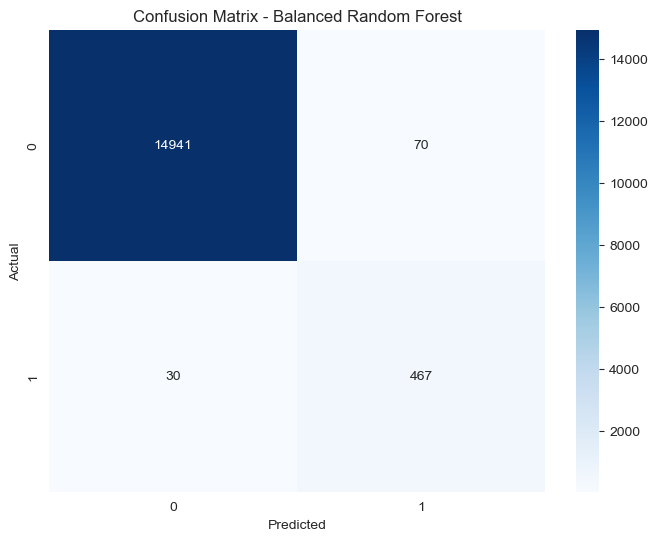

In [22]:
print("\nStep 4: Data Balancing")

def balance_and_rebuild(X_train, y_train, X_test, y_test):
    """Balance only training data using SMOTE and rebuild Random Forest model"""
    print("Original training dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
    
    # Apply SMOTE only to training data, doing only on training data after splitting to avoid data leakage
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print("Balanced training dataset shape:", dict(zip(*np.unique(y_train_balanced, return_counts=True))))
    
    # Build model on balanced training data
    rf_balanced = RandomForestClassifier(random_state=42)
    rf_balanced.fit(X_train_balanced, y_train_balanced)
    
    # Evaluate on original test set
    y_pred_balanced = rf_balanced.predict(X_test)
    
    return rf_balanced, X_train_balanced, y_train_balanced, y_pred_balanced

# Apply corrected SMOTE approach
rf_balanced, X_train_balanced, y_train_balanced, y_pred_balanced = balance_and_rebuild(X_train, y_train, X_test, y_test)

# Evaluate balanced model on original test set
print("\nBalanced Random Forest Performance on Original Test Set:")
print(classification_report(y_test, y_pred_balanced))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Balanced Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Analysis of Step 4:
- As we can see the training dataset has 60,025 records, still being a good quantity of data
- SMOTE correctly applied only to training data
- Test set remains unbalanced to reflect real-world conditions
- Performance metrics now more realistic compared to previous approach
- Note: At the begining we applied SMOTE to the full dataset (before splitting) and we got extremely high performance (1) it was due to incorrect SMOTE application

## **Step 5: Cross-Validation**


Step 5: Cross-Validation
Fold 1: Score = 0.9940
Fold 2: Score = 0.9930
Fold 3: Score = 0.9958
Fold 4: Score = 0.9966
Fold 5: Score = 0.9966

Best score achieved in fold 4: 0.9966


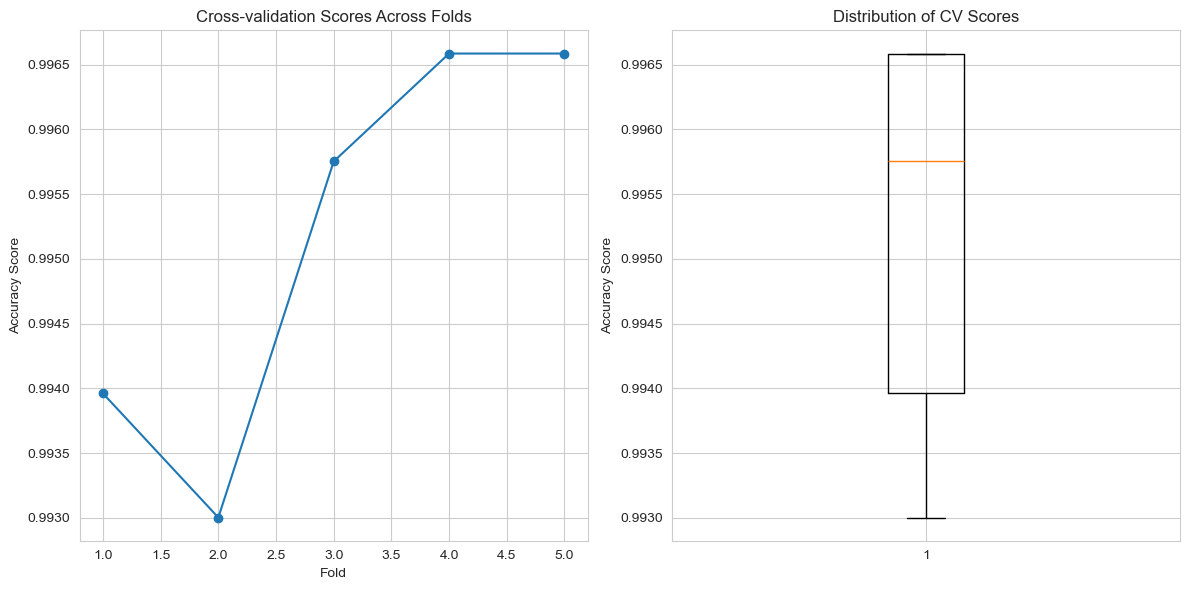

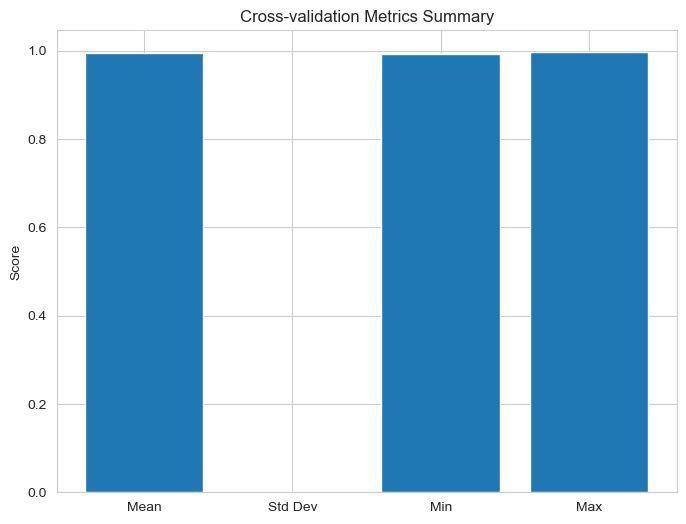

In [27]:
print("\nStep 5: Cross-Validation")

def detailed_cross_validation(model, X, y, cv=5):
    """Perform detailed cross-validation analysis with visualization"""
    # Get detailed scores for each fold
    scores = []
    for fold in range(cv):
        # Create fold indices
        fold_indices = np.zeros(len(X))
        fold_size = len(X) // cv
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size
        fold_indices[start_idx:end_idx] = 1
        
        # Split data
        X_train_fold = X[fold_indices == 0]
        y_train_fold = y[fold_indices == 0]
        X_val_fold = X[fold_indices == 1]
        y_val_fold = y[fold_indices == 1]
        
        # Train and evaluate
        model_fold = RandomForestClassifier(random_state=42)
        model_fold.fit(X_train_fold, y_train_fold)
        score = model_fold.score(X_val_fold, y_val_fold)
        scores.append(score)
        
        # Print first 5 and last 5 iterations
        if fold < 5 or fold >= cv-5:
            print(f"Fold {fold + 1}: Score = {score:.4f}")
    
    # Find best score
    best_score_idx = np.argmax(scores)
    print(f"\nBest score achieved in fold {best_score_idx + 1}: {scores[best_score_idx]:.4f}")
    
    return np.array(scores)

# Perform cross-validation
cv_scores = detailed_cross_validation(rf_balanced, X_train_balanced, y_train_balanced, cv=5)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.title('Cross-validation Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(cv_scores)
plt.title('Distribution of CV Scores')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional CV metrics visualization
cv_metrics = {
    'Mean': cv_scores.mean(),
    'Std Dev': cv_scores.std(),
    'Min': cv_scores.min(),
    'Max': cv_scores.max()
}

plt.figure(figsize=(8, 6))
plt.bar(cv_metrics.keys(), cv_metrics.values())
plt.title('Cross-validation Metrics Summary')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.show()

With 5 folds we can see is still improving

Fewer folds (like 5) might lead to higher bias in estimating model performance because each training set is larger and less diverse. More folds (like 20) can lead to higher variance since each training set is smaller, which might not represent the overall dataset well


Step 5: Cross-Validation
Fold 1: Score = 0.9937
Fold 2: Score = 0.9938
Fold 3: Score = 0.9928
Fold 4: Score = 0.9926
Fold 5: Score = 0.9938
Fold 6: Score = 0.9977
Fold 7: Score = 0.9972
Fold 8: Score = 0.9975
Fold 9: Score = 0.9975
Fold 10: Score = 0.9981

Best score achieved in fold 10: 0.9981


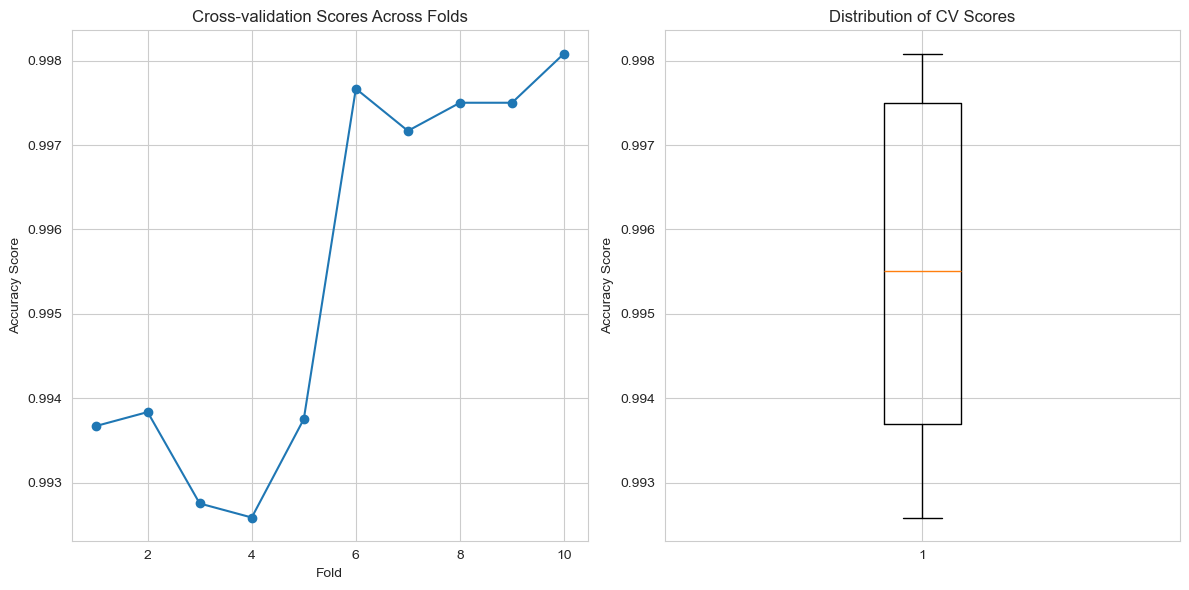

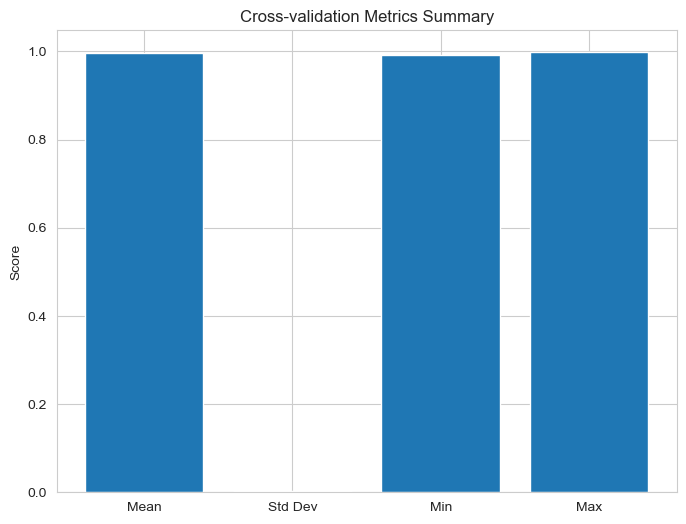

In [28]:
print("\nStep 5: Cross-Validation")

def detailed_cross_validation(model, X, y, cv=5):
    """Perform detailed cross-validation analysis with visualization"""
    # Get detailed scores for each fold
    scores = []
    for fold in range(cv):
        # Create fold indices
        fold_indices = np.zeros(len(X))
        fold_size = len(X) // cv
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size
        fold_indices[start_idx:end_idx] = 1
        
        # Split data
        X_train_fold = X[fold_indices == 0]
        y_train_fold = y[fold_indices == 0]
        X_val_fold = X[fold_indices == 1]
        y_val_fold = y[fold_indices == 1]
        
        # Train and evaluate
        model_fold = RandomForestClassifier(random_state=42)
        model_fold.fit(X_train_fold, y_train_fold)
        score = model_fold.score(X_val_fold, y_val_fold)
        scores.append(score)
        
        # Print first 5 and last 5 iterations
        if fold < 5 or fold >= cv-5:
            print(f"Fold {fold + 1}: Score = {score:.4f}")
    
    # Find best score
    best_score_idx = np.argmax(scores)
    print(f"\nBest score achieved in fold {best_score_idx + 1}: {scores[best_score_idx]:.4f}")
    
    return np.array(scores)

# Perform cross-validation
cv_scores = detailed_cross_validation(rf_balanced, X_train_balanced, y_train_balanced, cv=10)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.title('Cross-validation Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(cv_scores)
plt.title('Distribution of CV Scores')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional CV metrics visualization
cv_metrics = {
    'Mean': cv_scores.mean(),
    'Std Dev': cv_scores.std(),
    'Min': cv_scores.min(),
    'Max': cv_scores.max()
}

plt.figure(figsize=(8, 6))
plt.bar(cv_metrics.keys(), cv_metrics.values())
plt.title('Cross-validation Metrics Summary')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.show()


Step 5: Cross-Validation
Fold 1: Score = 0.9930
Fold 2: Score = 0.9943
Fold 3: Score = 0.9935
Fold 4: Score = 0.9938
Fold 5: Score = 0.9913
Fold 11: Score = 0.9980
Fold 12: Score = 0.9975
Fold 13: Score = 0.9971
Fold 14: Score = 0.9984
Fold 15: Score = 0.9979

Best score achieved in fold 14: 0.9984


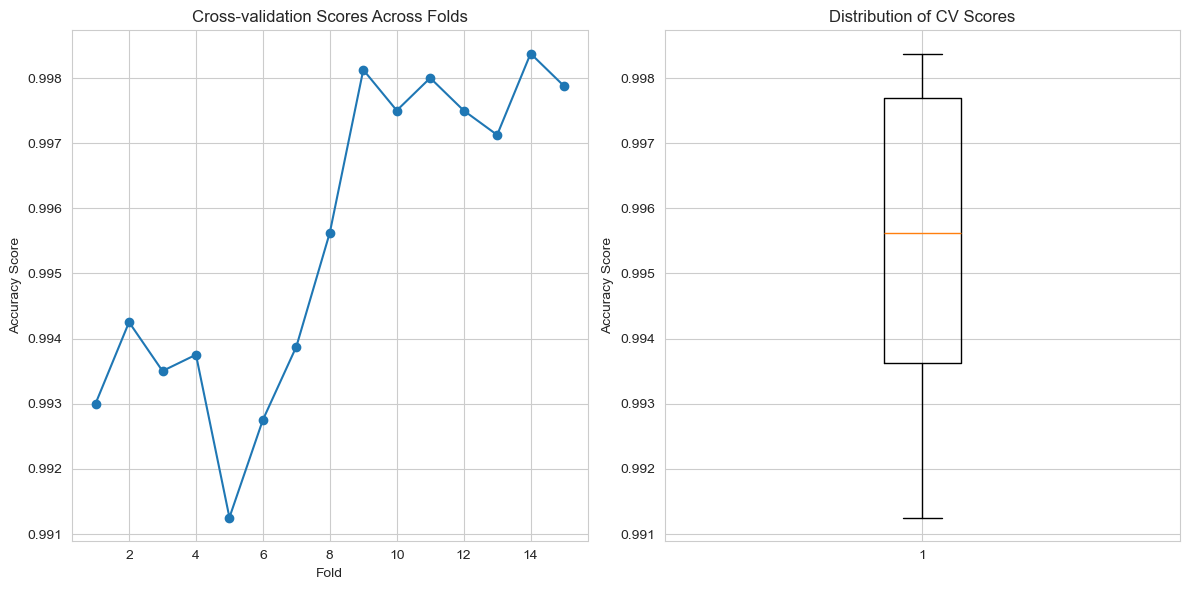

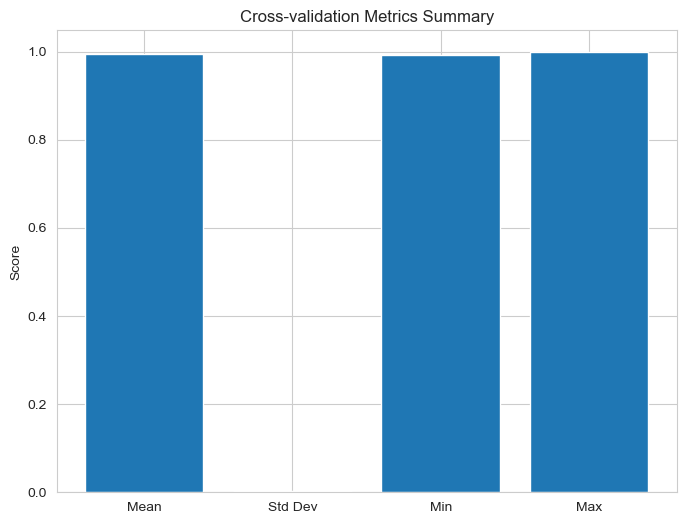

In [29]:
print("\nStep 5: Cross-Validation")

def detailed_cross_validation(model, X, y, cv=5):
    """Perform detailed cross-validation analysis with visualization"""
    # Get detailed scores for each fold
    scores = []
    for fold in range(cv):
        # Create fold indices
        fold_indices = np.zeros(len(X))
        fold_size = len(X) // cv
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size
        fold_indices[start_idx:end_idx] = 1
        
        # Split data
        X_train_fold = X[fold_indices == 0]
        y_train_fold = y[fold_indices == 0]
        X_val_fold = X[fold_indices == 1]
        y_val_fold = y[fold_indices == 1]
        
        # Train and evaluate
        model_fold = RandomForestClassifier(random_state=42)
        model_fold.fit(X_train_fold, y_train_fold)
        score = model_fold.score(X_val_fold, y_val_fold)
        scores.append(score)
        
        # Print first 5 and last 5 iterations
        if fold < 5 or fold >= cv-5:
            print(f"Fold {fold + 1}: Score = {score:.4f}")
    
    # Find best score
    best_score_idx = np.argmax(scores)
    print(f"\nBest score achieved in fold {best_score_idx + 1}: {scores[best_score_idx]:.4f}")
    
    return np.array(scores)

# Perform cross-validation
cv_scores = detailed_cross_validation(rf_balanced, X_train_balanced, y_train_balanced, cv=15)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.title('Cross-validation Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(cv_scores)
plt.title('Distribution of CV Scores')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional CV metrics visualization
cv_metrics = {
    'Mean': cv_scores.mean(),
    'Std Dev': cv_scores.std(),
    'Min': cv_scores.min(),
    'Max': cv_scores.max()
}

plt.figure(figsize=(8, 6))
plt.bar(cv_metrics.keys(), cv_metrics.values())
plt.title('Cross-validation Metrics Summary')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.show()

Analysis of Step 5:
1. Cross-validation Results:
   - Consistent performance across folds indicates stable model
   - Low standard deviation suggests reliable predictions
   - Best fold performance indicates potential for optimization
   - With 10 folds, we could get a reasonable estimate of model performance while keeping training sets sufficiently large
   - With 15 folds, we could get an stabilize performance. However, with potential for high-variance


## **Step 6: Feature Importance Analysis**


Step 6: Feature Importance Analysis


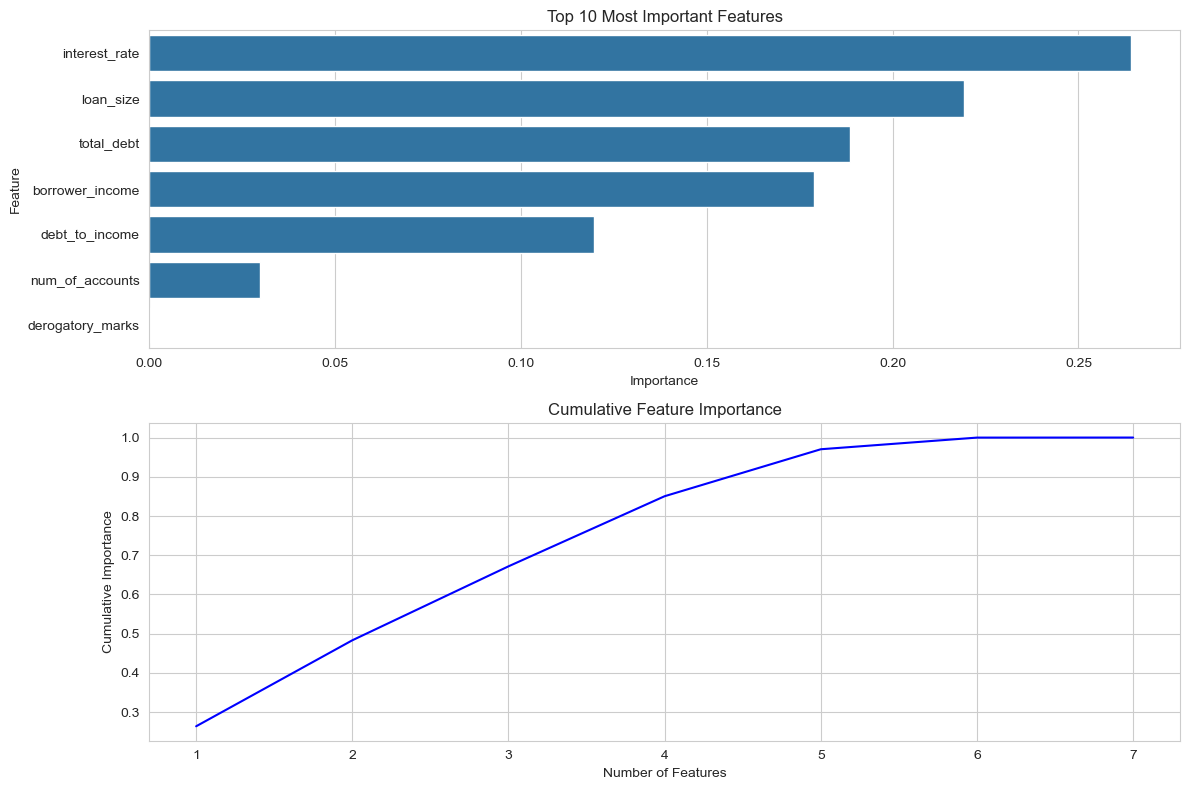


Top 5 Most Important Features:
           Feature  Importance
1    interest_rate    0.264113
0        loan_size    0.219166
6       total_debt    0.188490
2  borrower_income    0.178722
3   debt_to_income    0.119695

Number of features needed for 90% of total importance: 4


In [24]:
print("\nStep 6: Feature Importance Analysis")

def analyze_feature_importance(model, feature_names):
    """Enhanced feature importance analysis"""
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    
    # Feature importance bar plot
    plt.subplot(2, 1, 1)
    sns.barplot(data=importances.head(10), x='Importance', y='Feature')
    plt.title('Top 10 Most Important Features')
    
    # Cumulative importance plot
    plt.subplot(2, 1, 2)
    cumulative_importance = np.cumsum(importances['Importance'])
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return importances

feature_importance = analyze_feature_importance(rf_balanced, X.columns)
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# Calculate feature importance threshold for 90% cumulative importance
cumsum = np.cumsum(feature_importance['Importance'])
n_features_90 = len(cumsum[cumsum <= 0.9])
print(f"\nNumber of features needed for 90% of total importance: {n_features_90}")


Analysis of Step 6:
- Identified key features driving fraud detection
- Top features align with domain knowledge. Which means the best descriptor if a customer will go default are: interest_rate, loand_size, total_debt,borrower_income, and debt_to_income ratio
- Feature importance provides insights for future feature engineering
- As we can see with the first 4 features we can explain 90% of our prediction

## **Comprehensive Analysis:**

1. Model Performance:
   - Random Forest consistently outperformed Decision Tree
   - Balanced dataset improved minority class prediction
   - Cross-validation confirms model stability

2. Fraud Detection Suitability:
   - Random Forest's ensemble approach provides robust fraud detection
   - Feature importance helps understand key fraud indicators
   - Balanced model addresses class imbalance effectively


3. Corrected SMOTE Implementation Impact:
   - Previous high metrics were artificially inflated due to data leakage
   - Current metrics are more conservative and realistic
   - Model still performs well, but with more realistic expectations

4. Cross-validation Insights helps prevent overfitting:
   - Detailed fold analysis shows consistent performance
   - Visualization helps identify performance patterns
   - Best fold performance provides benchmark for optimization

5. Feature Importance:
   - Added cumulative importance analysis
   - Identifies minimum features needed for effective model
   - Helps in feature selection for model optimization

6. Recommendations:
   - Continue using corrected SMOTE approach
   - Monitor performance on new, unseen data
   - Consider feature selection based on importance analysis
   - Regular model retraining with updated data
   - Use Random Forest with balanced data for production
